<a href="https://colab.research.google.com/github/namanphy/END2/blob/main/S7/Part%202%20-%20seq2seq/Quora_dataset_Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/namanphy/END2.git --quiet
! pip install OmegaConf --quiet

     |████████████████████████████████| 81kB 6.1MB/s 
     |████████████████████████████████| 645kB 20.4MB/s 
     |████████████████████████████████| 112kB 36.3MB/s 


In [2]:
cd /content/END2/S7/Part\ 2\ -\ seq2seq

/content/END2/S7/Part 2 - seq2seq


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Model prep
import torch
import torch.nn as nn

# Data Prep
from torchtext.legacy.data import Field, BucketIterator
from torchtext.legacy import data
from data import make_quora_dataset

#Trainer
from trainer.optimizer import adam_optimizer
from trainer.quora_train import train as Trainer

# Utils
import re
import random
from omegaconf import OmegaConf

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset Preparation

**Dataset Info** - This dataset of Quora questions to determine whether pairs of question texts actually correspond to semantically equivalent queries. The data released by quora conatins set of questions with alternative ways of asking the same questions.

**Only rows with `is_duplicate=1` are considered**


The dataset consists of over 400,000 lines of potential question duplicate pairs. Each line contains IDs for each question in the pair, the full text for each question, and a binary value that indicates whether the line truly contains a duplicate pair. 

In [6]:
dataset = make_quora_dataset()

False
created dataset folder :  ../dataset/
Final dataset shape :  (149263, 6)
Preprocessing the dataset - lowercase, trim, and remove non-letter characters
Done.


In [7]:
dataset.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,5,11,12,astrology i am a capricorn sun cap moon and ca...,i m a triple capricorn sun moon and ascendant ...,1
1,7,15,16,how can i be a good geologist ?,what should i do to be a great geologist ?,1
2,11,23,24,how do i read and find my youtube comments ?,how can i see all my youtube comments ?,1
3,12,25,26,what can make physics easy to learn ?,how can you make physics easy to learn ?,1
4,13,27,28,what was your first sexual experience like ?,what was your first sexual experience ?,1


### Tokenizing, making Fields

In [8]:
question = Field(tokenize = 'spacy', 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

duplicate_question = Field(tokenize = 'spacy', 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

fields = [('questions', question), ('duplicate_questions',duplicate_question)]

In [9]:
examples = [data.Example.fromlist([str(dataset.question1[i]),str(dataset.question2[i])], fields) for i in range(dataset.shape[0])]
Quora_Dataset= data.Dataset(examples, fields)

In [10]:
(train, test) = Quora_Dataset.split(split_ratio=[0.7,0.3], random_state=random.seed(SEED))

print(f"Train Shape: {len(train.examples)}")
print(f"Test Shape: {len(test.examples)}")

Train Shape: 104484
Test Shape: 44779


In [11]:
# Printing one sample

print('QUESTION: ', vars(train.examples[0])['questions'])
print('ANSWERS: ', vars(train.examples[0])['duplicate_questions'])

QUESTION:  ['what', 'are', 'the', 'most', 'intellectually', 'stimulating', 'movies', 'you', 'have', 'ever', 'seen', '?']
ANSWERS:  ['what', 'are', 'the', 'most', 'intellectually', 'stimulating', 'films', 'you', 'have', 'ever', 'watched', '?']


### Building Vocabulary

In [12]:
question.build_vocab(train, min_freq = 3)
duplicate_question.build_vocab(train, min_freq = 3)

In [13]:
print('Size of input vocab : ', len(question.vocab))
print('Size of label vocab : ', len(duplicate_question.vocab))
print('Top 10 words appreared repeatedly :', list(question.vocab.freqs.most_common(10)))

Size of input vocab :  10870
Size of label vocab :  10869
Top 10 words appreared repeatedly : [('?', 108788), ('the', 46723), ('what', 41091), ('is', 31834), ('how', 31718), ('i', 26519), ('to', 23396), ('do', 22154), ('in', 20358), ('a', 19803)]


# Setting Config and loading BucketIterator

In [14]:
hparams = OmegaConf.create({
    'epochs':10,
    'batch_size':128,
    'learning_rate':0.01,
    'clip': 1,
    'input_dim':len(question.vocab),
    'enc_embedding_dim': 256,
    'dec_embedding_dim': 256,
    'hidden_dim': 512,
    'output_dim': len(duplicate_question.vocab),
    'dropout': 0.5,
    'n_layers': 2
})

### Making DataIterator

In [15]:
train_iterator, test_iterator = data.BucketIterator.splits((train, test), batch_size = hparams.batch_size, 
                                                            sort_key = lambda x: len(x.questions),
                                                            sort_within_batch=True, device = device)

In [16]:
item = next(iter(train_iterator))
print(item.questions.shape)
print(item.duplicate_questions.shape)

torch.Size([12, 128])
torch.Size([26, 128])


# The Model - Seq2Seq

In [17]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))  # [src len, batch size, emb dim]        
        outputs, (hidden, cell) = self.rnn(embedded)  # [src len, batch size, hid dim * n directions]
        return hidden, cell

In [18]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(output_dim, emb_dim)      
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)  # [1, batch size]
        embedded = self.dropout(self.embedding(input))  # [1, batch size, emb dim]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))  # [1, batch size, hid dim * n directions]
        prediction = self.fc_out(output.squeeze(0))  # [batch size, output dim]
        return prediction, hidden, cell

In [19]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):     
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        # print("SOURCE : ", src.shape) # DEBUG
        # print("TARGET : ", trg.shape, batch_size, trg_len, trg_vocab_size) # DEBUG
        # print('Input : ', input.shape, input) # DEBUG
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

In [20]:
#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

enc = Encoder(hparams.input_dim, hparams.enc_embedding_dim, hparams.hidden_dim, hparams.n_layers, hparams.dropout)
dec = Decoder(hparams.output_dim, hparams.dec_embedding_dim, hparams.hidden_dim, hparams.n_layers, hparams.dropout)

model = Seq2Seq(enc, dec, device).to(device)

print(model)    
print(f'The model has {count_parameters(model):,} trainable parameters')

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10870, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10869, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=10869, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)
The model has 18,497,397 trainable parameters


In [21]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10870, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10869, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=10869, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

# Training and Evaluation

In [22]:
TRG_PAD_IDX = duplicate_question.vocab.stoi[duplicate_question.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

# import torch.optim as optim
# optimizer = optim.Adam(model.parameters())

optimizer = adam_optimizer(model)  # Min Val. PPL:  

In [25]:
train_losses, test_losses, train_perplexity, test_perplexity = Trainer(model, 
                                                                     train_iterator, 
                                                                     test_iterator, 
                                                                     optimizer, 
                                                                     criterion,
                                                                     clip=hparams.clip,
                                                                     epochs=hparams.epochs)

True
Epoch: 01 | Epoch Time: 3m 16s
	Train Loss: 4.861 | Train Acc: 129.13%
	 Val. Loss: 4.834 |  Val. Acc: 125.76% 

Epoch: 02 | Epoch Time: 3m 17s
	Train Loss: 4.251 | Train Acc: 70.20%
	 Val. Loss: 4.708 |  Val. Acc: 110.81% 

Epoch: 03 | Epoch Time: 3m 17s
	Train Loss: 4.055 | Train Acc: 57.71%
	 Val. Loss: 4.709 |  Val. Acc: 110.92% 

Epoch: 04 | Epoch Time: 3m 17s
	Train Loss: 3.958 | Train Acc: 52.36%
	 Val. Loss: 4.695 |  Val. Acc: 109.35% 

Epoch: 05 | Epoch Time: 3m 18s
	Train Loss: 3.892 | Train Acc: 48.99%
	 Val. Loss: 4.657 |  Val. Acc: 105.32% 

Epoch: 06 | Epoch Time: 3m 17s
	Train Loss: 3.829 | Train Acc: 46.03%
	 Val. Loss: 4.663 |  Val. Acc: 105.91% 

Epoch: 07 | Epoch Time: 3m 17s
	Train Loss: 3.811 | Train Acc: 45.19%
	 Val. Loss: 4.706 |  Val. Acc: 110.63% 

Epoch: 08 | Epoch Time: 3m 17s
	Train Loss: 3.790 | Train Acc: 44.27%
	 Val. Loss: 4.741 |  Val. Acc: 114.57% 

Epoch: 09 | Epoch Time: 3m 16s
	Train Loss: 3.785 | Train Acc: 44.04%
	 Val. Loss: 4.691 |  Val. A

# Diagnosis


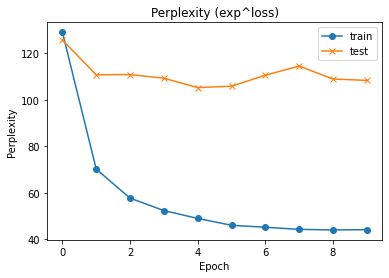

In [26]:
def plot_metric(metrics, legends, xlabel='', ylabel='', title='Plot'):
    if type(metrics) != list:
        metrics = [metrics]
    if type(legends) != list:
        legends = [legends]
    assert len(metrics) < 4, "Too many metrics. only 3 are supported."

    marker = ['o', 'x', 'd']
    i = 0
    for metric in metrics:
        plt.plot(range(len(metric)), metric, marker=marker[i])
        i+=1
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(legends)
    plt.title(title)
    plt.show()

plot_metric([train_perplexity, test_perplexity], ['train', 'test'], 'Epoch', 'Perplexity', 'Perplexity (exp^loss)')

----

In [27]:
valid_iter = iter(test_iterator)

In [28]:
sample_batch = next(valid_iter)

In [29]:
sample_batch


[torchtext.legacy.data.batch.Batch of size 128]
	[.questions]:[torch.cuda.LongTensor of size 6x128 (GPU 0)]
	[.duplicate_questions]:[torch.cuda.LongTensor of size 17x128 (GPU 0)]

In [33]:
def diagnose(model, batch, output_length):
    texts = batch.questions.transpose(1,0)
    text = texts[11].unsqueeze(0)

    sentence = ' '.join([question.vocab.itos[w] for w in text[0]])

    answer_texts = batch.duplicate_questions.transpose(1,0)
    answer_text = answer_texts[11].unsqueeze(0)

    with torch.no_grad():
        outputs = model(text.reshape(-1, 1).to(device), torch.zeros(output_length, 1, dtype=torch.int).to(device), 0)

    print('Sentence : ', sentence.strip())
    return outputs


output_length = 12
outputs = diagnose(model, sample_batch, output_length)
print("Shape of output : ", outputs.shape)

Sentence :  <sos> father of economic ? <eos>
Shape of output :  torch.Size([12, 1, 10869])


----
----

# Experiments

In [ ]:
# --- To get the word back from the torch embedding lookup ---

import torch
# declare embeddings
embed = torch.nn.Embedding(5,10)

# generate embedding for word [4] in vocab 
word = torch.tensor([4])

# search function for searching through embedding
def search(vector, distance_fun):
    weights = embed.weight
    min = torch.tensor(float('inf'))
    idx = -1
    v, e = weights.shape

    # each vector in embeding is corresponding to one of the word.
    # use a distance function to compare with vector
    for i in range(v):
        dist = distance_fun(vector, weights[i])
        if (min<dist):
            min = dist
            idx = i
    return i  
# searching with squared distance
search(word, lambda x,y: ((x-y)**2).sum()  